In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

from transformer.encoder import Encoder
from transformer.utils import WordTokenizer

In [2]:
config = {'num_heads': 12, 
          'vocab_size': 30522,
          'hidden_size': 128,
          'max_position_embeds': 512,
          'intermediate_size': 512,
          'dropout_p': 0.1,
          'input_size': (100,),
          'num_hidden_layers': 1}

## Get some toy data

The yelp sentence sentiment data set from Kaggle will do

In [3]:
rows = []
with open('yelp_labelled.txt', 'r') as FILE:
    while True:
        row = FILE.readline()
        if not row:
            break
        row = row.strip().split('\t')
        sentence = row[0]
        sentiment = int(row[1])
        rows.append({'sentence': sentence, 'sentiment': sentiment})
 
df = pd.DataFrame(rows, columns=['sentence', 'sentiment'])
df.head()

,sentence,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Tokenize the sentences and split into x and y 

y will be the last token of each sequence, so we can try to predict it. But mostly we just want to see if our transformer encoder trains.

In [4]:
tokenizer = WordTokenizer(make_mask=True)
config['vocab_size'] = tokenizer.fit(df['sentence'].values)
tokens, masks = tokenizer.transform(df['sentence'].values,
                             max_len=config['input_size'][0])

X = np.array([[0] + s[:-1] for s in tokens.tolist()])
y = np.array([s[-1] for s in tokens])
masks = np.array([[0] + m[:-1] for m in masks.tolist()])

print(f'Number of sentences: {df.shape[0]}')
print(f'Vocabulary size: {config["vocab_size"]}')

Number of sentences: 1000
Vocabulary size: 2971


## Try our transformer!

We'll just train our encoder by the task of predicting the last word of each sentence

In [5]:
token_input = Input(shape=config['input_size'])
mask_input = Input(shape=config['input_size'])
x = Encoder(config)([token_input, mask_input])
x = GlobalAveragePooling1D()(x)
output = Dense(config['vocab_size'], activation='softmax')(x)

clf = Model(inputs=[token_input, mask_input], outputs=output)

clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 Encoder (Encoder)              (None, 100, 128)     640232      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 global_average_pooling1d (Glob  (None, 128)         0           ['Encoder[0][0]']            

In [6]:
clf.compile(optimizer=Adam(learning_rate=0.0005), 
            loss='sparse_categorical_crossentropy')
hist = clf.fit([X, masks],
               y,
               epochs=200)

Epoch 1/200
32/32 [==============================] - 14s 145ms/step - loss: 7.7310
Epoch 2/200
32/32 [==============================] - 5s 149ms/step - loss: 6.4961
Epoch 3/200
32/32 [==============================] - 5s 143ms/step - loss: 6.2537
Epoch 4/200
32/32 [==============================] - 4s 139ms/step - loss: 6.1788
Epoch 5/200
32/32 [==============================] - 4s 139ms/step - loss: 6.0760
Epoch 6/200
32/32 [==============================] - 5s 141ms/step - loss: 5.9436
Epoch 7/200
32/32 [==============================] - 5s 141ms/step - loss: 5.7278
Epoch 8/200
32/32 [==============================] - 5s 151ms/step - loss: 5.3913
Epoch 9/200
32/32 [==============================] - 5s 155ms/step - loss: 4.9447
Epoch 10/200
32/32 [==============================] - 5s 151ms/step - loss: 4.2744
Epoch 11/200
32/32 [==============================] - 5s 143ms/step - loss: 3.5494
Epoch 12/200
32/32 [==============================] - 5s 143ms/step - loss: 2.8348
Epoch 13/200

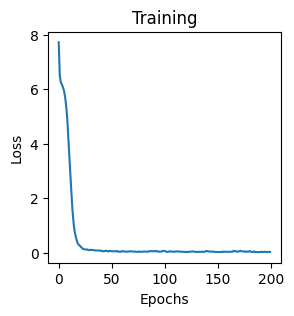

In [7]:
plt.figure(figsize=(3,3))
plt.plot(hist.history['loss'])
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


## Test our toy model

Make up a few sentences that may belong to the distribution (Yelp restaraunt review sentences).

Then, dropping off that last word of each, try to complete them. 


In [9]:
s = ["It really tasted awful.",
     "It was very good.",
     "It was awful.",
     "This is a very bad place.",
     "The spaghetti was perfect",
     "The eggs were gross!",
     "My steak was bad."]

# Tokenize our sentence, separate last word, and pad
tokens_test, masks_tests = tokenizer.transform(s, max_len=config['input_size'][0])

X_test = np.array([[0] + s[:-1] for s in tokens_test.tolist()])
y_test = np.array([s[-1] for s in tokens])
masks_test = np.array([[0] + m[:-1] for m in masks_tests.tolist()])

# Predict last word
y_hat = clf.predict([X_test, masks_test])
y_hat = np.argmax(y_hat, axis=1)

for i in range(len(s)):
     # construct predicted complete sentence
     pred_s = X_test[i].tolist()
     pred_s.append(y_hat[i])

     #unpad
     pred_s = [token for token in pred_s if token!= 0]
     pred_s = ' '.join([tokenizer.vocab_reverse[i] for i in pred_s])
     print(f'\nOriginal sentence: {s[i]}\nCompleted sentence: {pred_s}')




1/1 [==============================] - 1s 1s/step

Original sentence: It really tasted awful.
Completed sentence: It really tasted here!!!"

Original sentence: It was very good.
Completed sentence: It was very good.

Original sentence: It was awful.
Completed sentence: It was packed!!

Original sentence: This is a very bad place.
Completed sentence: This is a very bad overpriced.

Original sentence: The spaghetti was perfect
Completed sentence: The spaghetti was huge!

Original sentence: The eggs were gross!
Completed sentence: The eggs were door.

Original sentence: My steak was bad.
Completed sentence: My steak was too!


## Save encoder model

Omitting the classifier head

In [14]:
input1, input2 = clf.input
encoder_model = tf.keras.models.Model(inputs=[input1, input2],
                                      outputs=clf.layers[-2].output)
encoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 Encoder (Encoder)              (None, 100, 128)     640232      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 global_average_pooling1d (Glob  (None, 128)         0           ['Encoder[0][0]']          

In [15]:
save_model(encoder_model, 'encoder_model.h5')